In [29]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

In [6]:
Train_data = pd.read_csv('./used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv('./used_car_testB_20200421.csv', sep=' ')
print('Train data shape:',Train_data.shape)
print('TestA data shape:',Test_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [7]:
# 合并方便后面的操作
df = pd.concat([Train_data, Test_data], ignore_index=True)

In [8]:
#查看数据信息
df.info()
#查看缺失值
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             200000 non-null  int64  
 1   name               200000 non-null  int64  
 2   regDate            200000 non-null  int64  
 3   model              199999 non-null  float64
 4   brand              200000 non-null  int64  
 5   bodyType           193990 non-null  float64
 6   fuelType           188396 non-null  float64
 7   gearbox            192051 non-null  float64
 8   power              200000 non-null  int64  
 9   kilometer          200000 non-null  float64
 10  notRepairedDamage  200000 non-null  object 
 11  regionCode         200000 non-null  int64  
 12  seller             200000 non-null  int64  
 13  offerType          200000 non-null  int64  
 14  creatDate          200000 non-null  int64  
 15  price              150000 non-null  float64
 16  v_

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              6010
fuelType             11604
gearbox               7949
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                50000
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

In [9]:
#类别特征nunique分布
cat_fea = ['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
           'gearbox', 'kilometer', 'notRepairedDamage', 'regionCode',
           'seller', 'offerType', 'creatDate']
for fea in cat_fea:
    print(fea + "的特征分布如下：")
    print("{}特征有个{}不同的值".format(fea,df[fea].nunique()))
    print(df[fea].value_counts())

name的特征分布如下：
name特征有个128660不同的值
387      376
55       373
708      367
1541     349
203      311
        ... 
45755      1
47802      1
53943      1
55990      1
4094       1
Name: name, Length: 128660, dtype: int64
regDate的特征分布如下：
regDate特征有个3898不同的值
20000008    235
20000011    213
20000002    211
20000009    206
20000001    205
           ... 
19910807      1
20151209      1
19910909      1
19910801      1
20151201      1
Name: regDate, Length: 3898, dtype: int64
model的特征分布如下：
model特征有个248不同的值
0.0      15534
19.0     12799
4.0      11235
1.0       8019
29.0      6964
         ...  
243.0        4
244.0        4
242.0        3
240.0        2
247.0        1
Name: model, Length: 248, dtype: int64
brand的特征分布如下：
brand特征有个40不同的值
0     41953
4     22269
14    21434
10    18962
1     18421
6     13717
9      9666
5      6150
13     5203
11     3887
3      3281
7      3088
16     2993
25     2792
8      2785
27     2676
21     2090
15     1934
19     1861
20     1647
12     1508
22     1443
2

<Figure size 432x288 with 0 Axes>

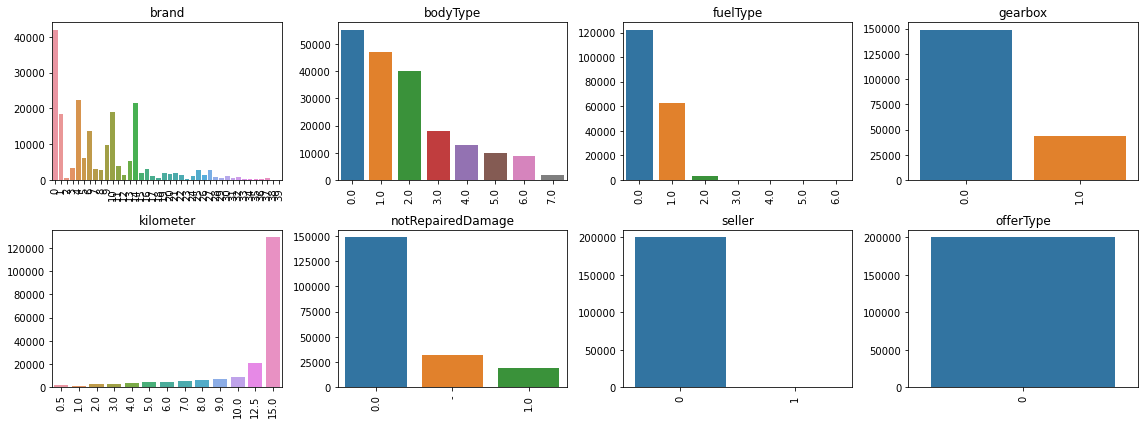

In [10]:
#类别特征取值较少的，画出直方图,
#'notRepairedDamage'存在无效字符，'seller,offerType'数值分布极不平衡
plt.figure()
plt.figure(figsize=(16, 6))
i = 1
for fea in cat_fea:
    if df[fea].nunique()<50:
        plt.subplot(2, 4, i)
        i += 1
        v = df[fea].value_counts()
        fig = sns.barplot(x=v.index, y=v.values)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(fea)
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

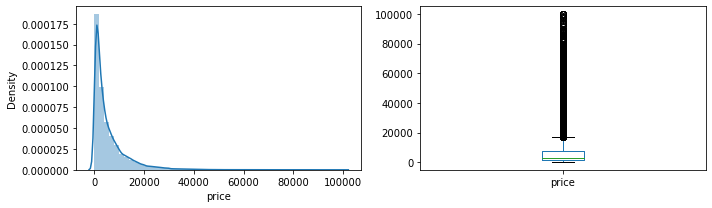

In [11]:
#'price'为长尾分布，需要做数据转换
plt.figure()
plt.figure(figsize=(10, 3))
plt.subplot(1, 2,1)
sns.distplot(Train_data['price'])
plt.subplot(1,2,2)
Train_data['price'].plot.box()
plt.tight_layout()

<AxesSubplot:xlabel='price', ylabel='Density'>

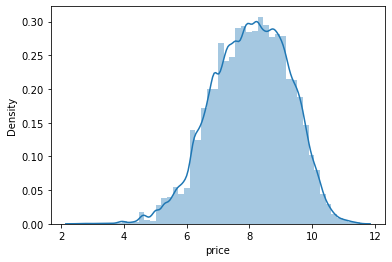

In [12]:
#'price'转化后的分布
plt.figure()
sns.distplot(np.log1p(Train_data['price']))

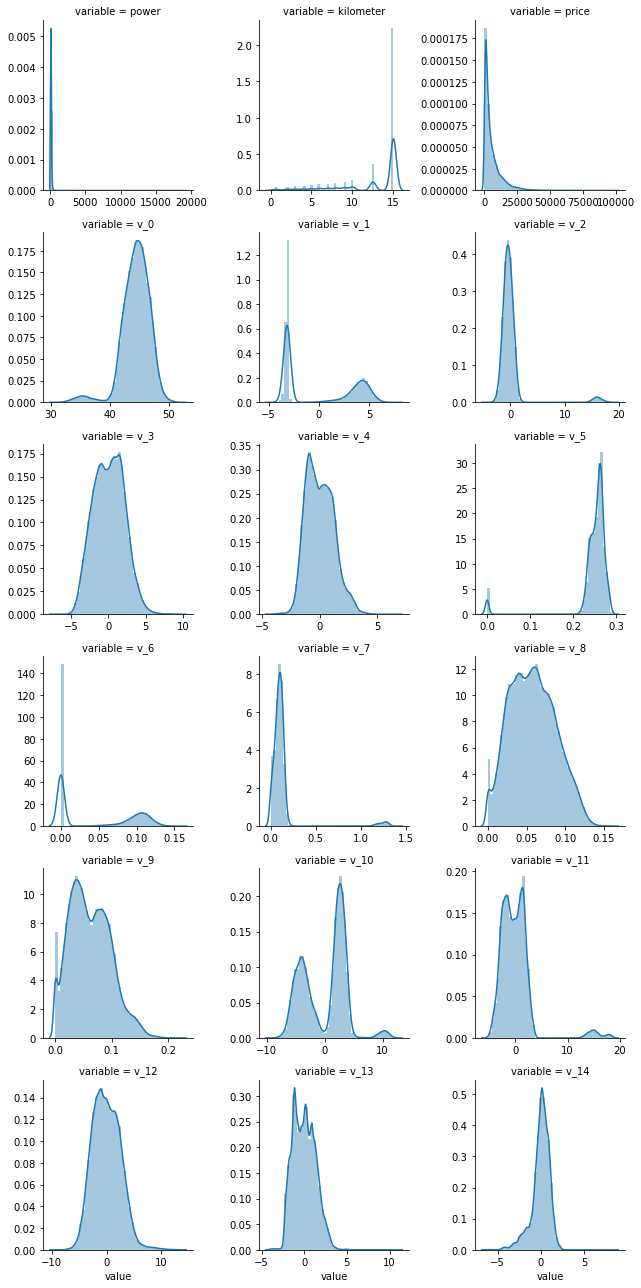

In [13]:
#数值特征分布，'power'的分布比较奇怪，后面做处理
num_fea = ['power', 'kilometer','price','v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14']

f = pd.melt(Train_data, value_vars=num_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

<Figure size 432x288 with 0 Axes>

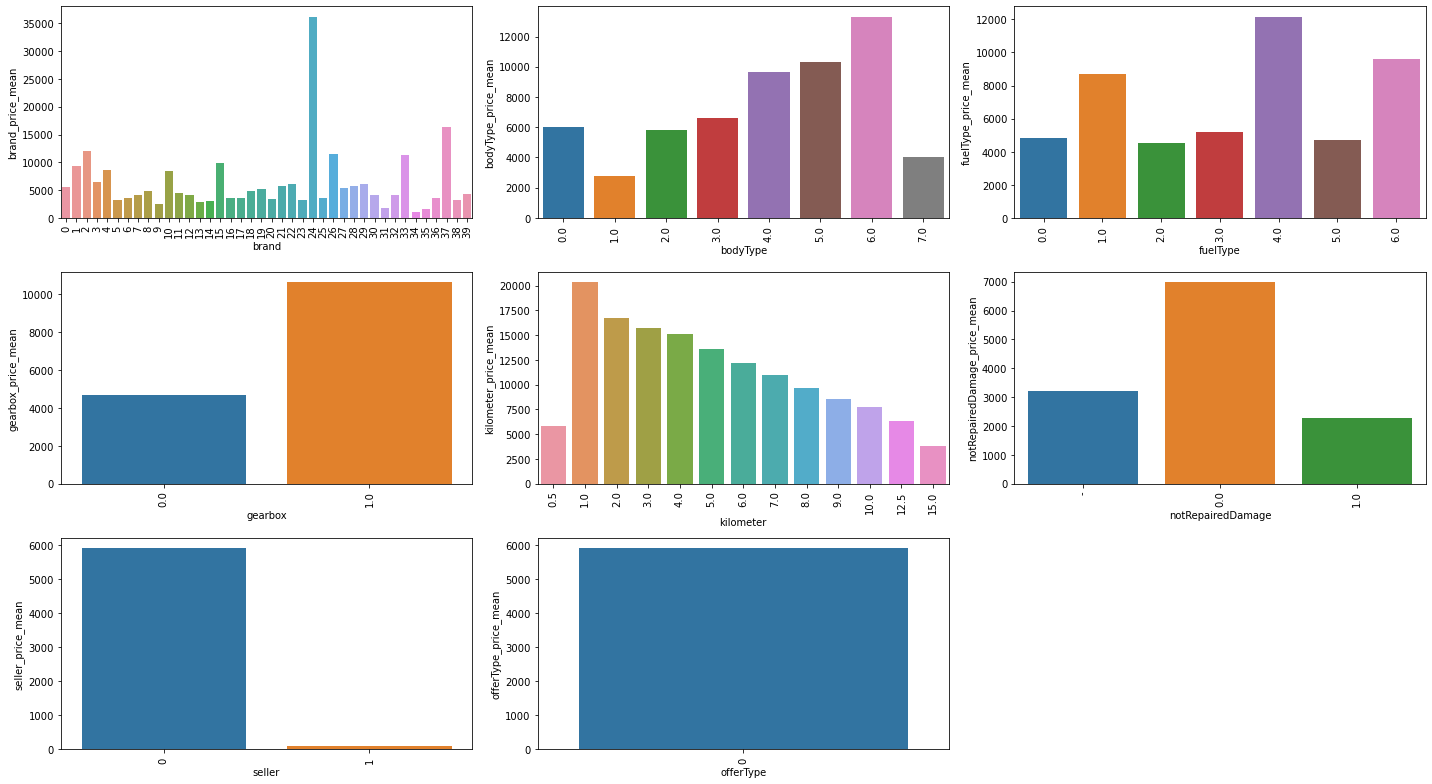

In [14]:
#选取类别特征取值较少的，观察它们与价格的均值分布，其中'kilometer'对价格的影响很明显
plt.figure()
plt.figure(figsize=(20, 18))
i = 1
for f in cat_fea:
    if df[f].nunique() <= 50:
        plt.subplot(5, 3, i)
        i += 1
        v = df[~df['price'].isnull()].groupby(f,as_index=False)['price'].agg({f + '_price_mean': 'mean'}).reset_index()
        fig = sns.barplot(x=f, y=f + '_price_mean', data=v)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
plt.tight_layout()
plt.show()

<AxesSubplot:>

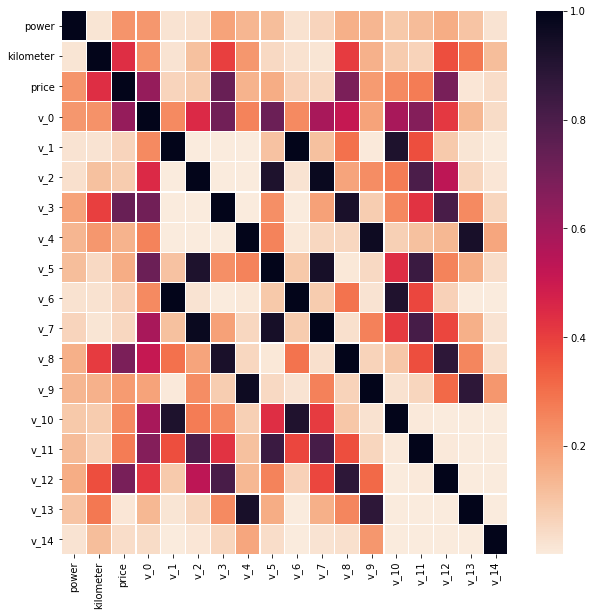

In [15]:
#匿名特征v_0,v_3,v_8,v_12与'price'相关性很高
corr1 = abs(df[df['price'].notnull()][num_fea].corr())
plt.figure(figsize=(10, 10))
sns.heatmap(corr1, linewidths=0.1, cmap=sns.cm.rocket_r)

In [16]:
#'name'有部分重复值，做一个简单统计
df['name_count'] = df.groupby(['name'])['SaleID'].transform('count')
del df['name']
del df['offerType']
del df['seller']

#对'price'做对数变换
df['price'] = np.log1p(df['price'])

In [17]:
#用众数填充缺失值
df['fuelType'] = df['fuelType'].fillna(0)
df['gearbox'] = df['gearbox'].fillna(0)
df['bodyType'] = df['bodyType'].fillna(0)
df['model'] = df['model'].fillna(0)

In [18]:
#处理异常值
df['power'] = df['power'].map(lambda x: 600 if x>600 else x)#赛题限定power<=600
df['notRepairedDamage'] = df['notRepairedDamage'].astype('str').apply(lambda x: x if x != '-' else None).astype('float32')

In [19]:
# 对可分类的连续特征进行分桶，kilometer是已经分桶了
bin = [i*10 for i in range(31)]
df['power_bin'] = pd.cut(df['power'], bin, labels=False)

bin = [i*10 for i in range(24)]
df['model_bin'] = pd.cut(df['model'], bin, labels=False)

In [20]:
#时间提取出年，月，日和使用时间
from datetime import datetime
def date_process(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])

    if month < 1:
        month = 1

    date = datetime(year, month, day)
    return date

df['regDate'] = df['regDate'].apply(date_process)
df['creatDate'] = df['creatDate'].apply(date_process)
df['regDate_year'] = df['regDate'].dt.year
df['regDate_month'] = df['regDate'].dt.month
df['regDate_day'] = df['regDate'].dt.day
df['creatDate_year'] = df['creatDate'].dt.year
df['creatDate_month'] = df['creatDate'].dt.month
df['creatDate_day'] = df['creatDate'].dt.day
df['car_age_day'] = (df['creatDate'] - df['regDate']).dt.days#二手车使用天数
df['car_age_year'] = round(df['car_age_day'] / 365, 1)#二手车使用年数

In [21]:
#类别特征对价格的统计最大，最小，平均值等等
cat_cols = ['brand','model','kilometer','fuelType','bodyType']
for col in cat_cols:
    t = Train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    df = pd.merge(df,t,on=col,how='left')

#行驶路程与功率统计
kk = ['kilometer','power']
t1 = Train_data.groupby(kk[0],as_index=False)[kk[1]].agg(
        {kk[0]+'_'+kk[1]+'_count':'count',kk[0]+'_'+kk[1]+'_max':'max',kk[0]+'_'+kk[1]+'_median':'median',
         kk[0]+'_'+kk[1]+'_min':'min',kk[0]+'_'+kk[1]+'_sum':'sum',kk[0]+'_'+kk[1]+'_std':'std',kk[0]+'_'+kk[1]+'_mean':'mean'})
df = pd.merge(df,t1,on=kk[0],how='left')

In [22]:
num_cols = [0,3,8,12]
for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'*'+str(j)]=df['v_'+str(i)]*df['v_'+str(j)]
        
for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'+'+str(j)]=df['v_'+str(i)]+df['v_'+str(j)]

for i in num_cols:
    for j in num_cols:
        df['new'+str(i)+'-'+str(j)]=df['v_'+str(i)]-df['v_'+str(j)]

for i in range(15):
    df['new'+str(i)+'*year']=df['v_'+str(i)] * df['car_age_year']

In [23]:
#划分训练数据和测试数据
df1 = df.copy()
test = df1[df1['price'].isnull()]
X_train = df1[df1['price'].notnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)
Y_train = df1[df1['price'].notnull()]['price']
X_test = df1[df1['price'].isnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)

In [30]:
cols = list(X_train)
oof = np.zeros(X_train.shape[0])
sub = test[['SaleID']].copy()
sub['price'] = 0
feat_df = pd.DataFrame({'feat': cols, 'imp': 0})
skf = KFold(n_splits=5, shuffle=True, random_state=2020)

clf = LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.02,
    boosting_type= 'gbdt',
    objective = 'regression_l1',
    max_depth = -1,
    num_leaves=31,
    min_child_samples = 20,
    feature_fraction = 0.8,
    bagging_freq = 1,
    bagging_fraction = 0.8,
    lambda_l2 = 2,
    random_state=2020,
    metric='mae'
)

mae = 0
for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
    print('--------------------- {} fold ---------------------'.format(i+1))
    trn_x, trn_y = X_train.iloc[trn_idx].reset_index(drop=True), Y_train[trn_idx]
    val_x, val_y = X_train.iloc[val_idx].reset_index(drop=True), Y_train[val_idx]
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        eval_metric='mae',
        early_stopping_rounds=300,
        verbose=300
    )
    
    sub['price'] += np.expm1(clf.predict(X_test)) / skf.n_splits
    oof[val_idx] = clf.predict(val_x)
    print('val mae:', mean_absolute_error(np.expm1(val_y), np.expm1(oof[val_idx])))
    mae += mean_absolute_error(np.expm1(val_y), np.expm1(oof[val_idx]))/skf.n_splits

print('cv mae:', mae)
#生成提交文件
sub.to_csv('sumbit.csv',index=False)

--------------------- 1 fold ---------------------
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 300 rounds
[300]	valid_0's l1: 0.147762
[600]	valid_0's l1: 0.131209
[900]	valid_0's l1: 0.125254
[1200]	valid_0's l1: 0.121728
[1500]	valid_0's l1: 0.119439
[1800]	valid_0's l1: 0.11787
[2100]	valid_0's l1: 0.116569
[2400]	valid_0's l1: 0.11558
[2700]	valid_0's l1: 0.114797
[3000]	valid_0's l1: 0.114111
[3300]	valid_0's l1: 0.113551
[3600]	valid_0's l1: 0.113065
[3900]	valid_0's l1: 0.112644
[4200]	valid_0's l1: 0.112265
[4500]	valid_0's l1: 0.

val mae: 454.59354073698745
cv mae: 460.61231006330695


In [28]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
